# Pubmed Topic Modeling 

 In this notebook I will be modeling topics for medical related articles, the dataset contains 5000 articles.
 Each document is matched to the top three most relevant topic names including the matching probability score.

### Importing the important libraries

In [1]:
import os
print(os.listdir("../input"))

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from wordcloud import WordCloud, STOPWORDS


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



['pubmed']


/opt/conda/lib/python3.6/site-packages/ipywidgets/widgets/widget.py:281: DeprecationWarning:

Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.



installing openpyxl for reading the excel file


In [2]:
pip install openpyxl


The following command must be run outside of the IPython shell:

    $ pip install openpyxl

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


# Loading the data

In [3]:
data = pd.read_excel("../input/pubmed/Pubmed5k.xlsx")
data['WholeText']=data['Title']+data['Abstract']
data.head()

,ArticleID,Title,Abstract,WholeText
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...,Stable Coordination Variability in Overground ...
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...,Weak Hip Strength Increases Dynamic Knee Valgu...
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...,Current and Future Projections of Amyotrophic ...
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...,Disparities between Asian and Non-Asian Thromb...
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...,Maternal Factors Predicting Loss to Follow-Up ...


#### Now that we have merged the columns that will be needed for the algorithms, lets dive into the preprocessing:

### Checking if there are null values

In [4]:
data.isnull().sum()

ArticleID    0
Title        0
Abstract     0
WholeText    0
dtype: int64

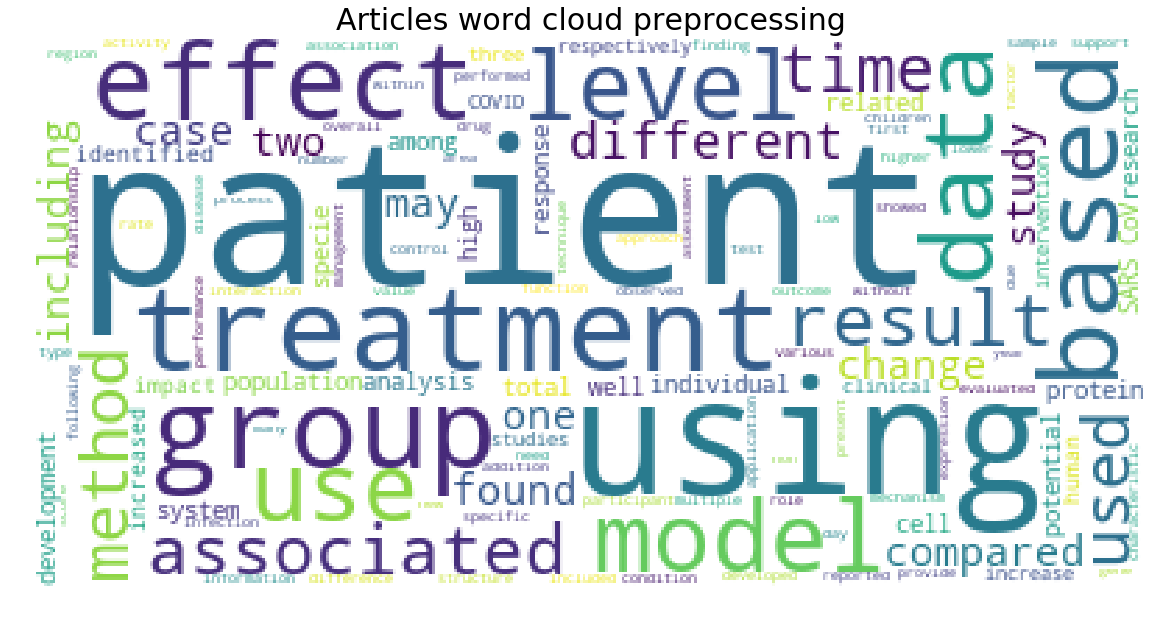

In [5]:
# The wordcloud of Articles
def make_word_cloud(data_cloud):
    """This function builds a word cloud with the given dataset"""
    plt.figure(figsize=(20,15))
    wc = WordCloud(background_color="White", max_words=10000, stopwords=STOPWORDS)
    wc.generate(" ".join(data_cloud['WholeText']))
    plt.title("Articles word cloud preprocessing", fontsize=30)
    plt.imshow(wc)
    plt.axis('off')
make_word_cloud(data)

In [6]:
all_words = data['WholeText'].str.split(expand=True).unstack().value_counts()
data_plot = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the Articles'
)

fig = go.Figure(data=data_plot, layout=layout)

py.iplot(fig, filename='basic-bar')

### From the word cloud and the most frequent words, we know that data preprocessing is needed before topic modeling

# Cleaning data:

### Stopwords are words that are commonly used. Using the popular NLTK package in python, lets import the stopwords in the english language
### and save it. It'll be used later for modeling purposes

In [7]:
# NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])

### The extended stopwords list from the scikit learn library:

In [8]:
st1= ['after', 'afterwards','again','against', 'all', 'almost','alone','along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'co',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'same',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves']

In [9]:
stop_words.extend(st1) 

#### Convert to list so we can do some pre-processing and Removing distracting characters:

In [10]:
# Convert to list
df = data.WholeText.values.tolist()
def remove_distracting_characters(df):
    """This function takes a list and removes the distracting characters then returns it"""
    # Remove new line characters
    df = [re.sub('\s+', ' ', sent) for sent in df]

    # Remove single quotes
    df = [re.sub("\'", "", sent) for sent in df]

    # Remove brackets
    df = [re.sub("\(", "", sent) for sent in df]
    df = [re.sub("\)", "", sent) for sent in df]

    # Remove percentage
    df = [re.sub("\%", "", sent) for sent in df]

    # Removing any emails
    df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

    # Remove dash and columns
    df = [re.sub("-", " ", sent) for sent in df]
    df = [re.sub(":", "", sent) for sent in df]
    return df
df=remove_distracting_characters(df)

pprint(df[:1])

['Stable Coordination Variability in Overground Walking and Running at '
 'Preferred and Fixed Speeds.Coordination variability CV is commonly analyzed '
 'to understand dynamical qualities of human locomotion. The purpose of this '
 'study was to develop guidelines for the number of trials required to inform '
 'the calculation of a stable mean lower limb CV during overground locomotion. '
 'Three dimensional lower limb kinematics were captured for 10 recreational '
 'runners performing 20 trials each of preferred and fixed speed walking and '
 'running. Stance phase CV was calculated for 9 segment and joint couplings '
 'using a modified vector coding technique. The number of trials required to '
 'achieve a CV mean within 10 of 20 strides average was determined for each '
 'coupling and individual. The statistical outputs of mode walking vs running '
 'and speed preferred vs fixed were compared when informed by differing '
 'numbers of trials. A minimum of 11 trials were required for

### All punctuations need to be removed, so lets write a function for that and we'll use the gensim package for that. deacc=TRUE does that. 

In [11]:
def sent_to_words(sentences):
    """This function takes a list and removes punctuations using gensim"""
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))

### N-gram models

### Creating Bigram and Trigram Models

### What are they? 

### Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Gensim's Phrases method helps us with that. 

In [12]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/opt/conda/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



### We need to apply the bigrams, trigrams and lemmatize the set of documents we are working with.

###  mm lemmatize ? ok  It is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

### To do that, lets create few functions. 

In [13]:
def remove_stopwords(texts):
    """This function removes stop words from text"""
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    """This function makes bigrams"""
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """This function makes trigrams"""
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """This function lemmatizes the text allowing nouns, adjectives, verbs and adverbs only"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Applying the custom functions to our dataset

In [14]:
# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### As we saw in the definition above, converting our document set into a document-term matrix.

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Readable format of corpus (term-frequency)

In [16]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('individual', 1),
  ('lead', 3),
  ('overall', 1),
  ('require', 1),
  ('variability', 1),
  ('associate', 2),
  ('clinical', 2),
  ('focus', 1),
  ('high', 1),
  ('include', 1),
  ('level', 1),
  ('current', 1),
  ('disease', 3),
  ('patient', 3),
  ('result', 1),
  ('female', 1),
  ('management', 1),
  ('treatment', 2),
  ('predict', 1),
  ('special', 1),
  ('efficacy', 1),
  ('significantly', 1),
  ('week', 1),
  ('anti', 1),
  ('antibody', 1),
  ('diagnostic', 1),
  ('genetic', 2),
  ('molecular', 1),
  ('option', 2),
  ('precision_medicine', 2),
  ('therapy', 3),
  ('life_expectancy', 1),
  ('progressive', 1),
  ('allow', 1),
  ('diagnosis', 2),
  ('facilitate', 1),
  ('form', 2),
  ('presentation', 1),
  ('renal', 1),
  ('strategy', 1),
  ('leucocyte', 1),
  ('limit', 1),
  ('residual', 1),
  ('drug', 1),
  ('account', 1),
  ('accumulation', 1),
  ('accurately', 1),
  ('active', 1),
  ('activity', 1),
  ('affect', 1),
  ('agalsidase', 2),
  ('amenable', 1),
  ('analyse', 1),
 

### Building the LDA model

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### Now that the model is built, lets print the Keyword in the 10 topics

In [18]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"infection" + 0.017*"virus" + 0.017*"case" + 0.016*"sars_cov" + '
  '0.012*"covid" + 0.010*"new" + 0.008*"antibody" + 0.008*"viral" + '
  '0.008*"present" + 0.006*"report"'),
 (1,
  '0.042*"cell" + 0.024*"cancer" + 0.012*"tumor" + 0.011*"expression" + '
  '0.007*"tissue" + 0.006*"lung" + 0.006*"treatment" + 0.005*"receptor" + '
  '0.005*"human" + 0.005*"chemotherapy"'),
 (2,
  '0.035*"patient" + 0.029*"study" + 0.018*"risk" + 0.014*"year" + '
  '0.013*"high" + 0.013*"group" + 0.011*"age" + 0.010*"factor" + '
  '0.010*"outcome" + 0.010*"associate"'),
 (3,
  '0.020*"study" + 0.013*"health" + 0.012*"care" + 0.010*"intervention" + '
  '0.009*"social" + 0.009*"quality" + 0.008*"use" + 0.008*"participant" + '
  '0.007*"experience" + 0.007*"support"'),
 (4,
  '0.022*"protein" + 0.020*"gene" + 0.008*"genetic" + 0.008*"sequence" + '
  '0.007*"identify" + 0.007*"induce" + 0.007*"specie" + 0.007*"analysis" + '
  '0.007*"pathway" + 0.006*"study"'),
 (5,
  '0.029*"use" + 0.019*"model"

### Right, now that the LDA model is built, there has to be a metric to evaluate how good the model is. Lets compute that to check how good it is. 


### There are 2 such metrics. 

### 1)   Perplexity -  Is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of k, you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents. - Lower the better.
### 2)  Coherence Score - Is defined as the average / median of the pairwise word-similarity scores of the words in the topic - Higher the better.
                          
                         

In [19]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.641374900166003

Coherence Score:  0.4598378391939521


> ** From the model we created, lets look at the most salient terms under each topic that contributes to it the most** 

### Note the graph below is interactive, please press on topic to see the most reprentative words for this topic. 

In [20]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.120498 -0.176873       1        1  18.546202
7     -0.136336  0.095762       2        1  13.285048
3     -0.235511  0.057139       3        1  12.090204
5     -0.117398 -0.110860       4        1   9.715571
6     -0.012731 -0.101765       5        1   9.619456
1      0.184183  0.001278       6        1   7.061686
9     -0.115076  0.197097       7        1   6.857263
4      0.130808  0.105103       8        1   6.816716
10     0.102032 -0.071324       9        1   6.678113
0      0.176099  0.196470      10        1   4.775362
8      0.144427 -0.192027      11        1   4.554369, topic_info=      Category         Freq   ...     loglift  logprob
term                          ...                     
181    Default  5450.000000   ...     30.0000  30.0000
409    Default  1892.000000   ...     29.0000  29.0000
165    Default  2415.000000   ...     28.0000  28.0000
239    Default  2308.000000   ...     27.0000  27.0000
126    Default  2177.000000   ...     26.0000  26.0000
1990   Default  1631.000000   ...     25.0000  25.0000
158    Default  1534.000000   ...     24.0000  24.0000
202    Default  1721.000000   ...     23.0000  23.0000
73     Default  4345.000000   ...     22.0000  22.0000
1693   Default  1086.000000   ...     21.0000  21.0000
702    Default  1131.000000   ...     20.0000  20.0000
1351   Default   824.000000   ...     19.0000  19.0000
290    Default  2072.000000   ...     18.0000  18.0000
907    Default  1368.000000   ...     17.0000  17.0000
750    Default   863.000000   ...     16.0000  16.0000
179    Default  2052.000000   ...     15.0000  15.0000
138    Default  1328.000000   ...     14.0000  14.0000
68     Default  6765.000000   ...     13.0000  13.0000
300    Default   986.000000   ...     12.0000  12.0000
82     Default  1283.000000   ...     11.0000  11.0000
261    Default  1191.000000   ...     10.0000  10.0000
299    Default  1132.000000   ...      9.0000   9.0000
417    Default  2334.000000   ...      8.0000   8.0000
83     Default  1574.000000   ...      7.0000   7.0000
105    Default  2803.000000   ...      6.0000   6.0000
734    Default   842.000000   ...      5.0000   5.0000
81     Default  1614.000000   ...      4.0000   4.0000
318    Default  1003.000000   ...      3.0000   3.0000
356    Default   736.000000   ...      2.0000   2.0000
1559   Default   527.000000   ...      1.0000   1.0000
...        ...          ...   ...         ...      ...
2251   Topic11    81.307312   ...      3.0781  -5.8831
1675   Topic11    80.920219   ...      3.0781  -5.8878
2253   Topic11    76.851753   ...      3.0775  -5.9394
6848   Topic11    76.025818   ...      3.0774  -5.9502
1807   Topic11    73.999802   ...      3.0770  -5.9772
1885   Topic11    73.303497   ...      3.0769  -5.9867
2249   Topic11    72.005699   ...      3.0767  -6.0046
1153   Topic11    71.345345   ...      3.0766  -6.0138
30647  Topic11    68.869095   ...      3.0761  -6.0491
4256   Topic11    65.642593   ...      3.0755  -6.0971
1103   Topic11    65.081665   ...      3.0754  -6.1057
725    Topic11    63.124641   ...      3.0750  -6.1362
1297   Topic11   364.847687   ...      2.8799  -4.3818
1515   Topic11   256.500763   ...      2.8262  -4.7342
602    Topic11   122.542114   ...      2.9312  -5.4728
766    Topic11   163.937332   ...      2.7568  -5.1818
794    Topic11   104.442139   ...      2.8926  -5.6327
239    Topic11   663.386230   ...      1.8421  -3.7839
734    Topic11   317.596832   ...      2.1135  -4.5205
274    Topic11   135.835480   ...      2.3864  -5.3699
5048   Topic11    81.816353   ...      2.9285  -5.8768
417    Topic11   178.776230   ...      0.5195  -5.0952
89     Topic11   144.294556   ...      0.9019  -5.3094
383    Topic11   131.974884   ...      1.1528  -5.3987
110    Topic11   105.391182   ...      1.9369  -5.6236
290    Topic11   145.305267   ...      0.4316  -5.3025
312    Top

**Let’s interpret the topic visualization. Notice how topics are shown on the left while words are on the right. Here are the main things you should consider:**

**Larger topics are more frequent in the corpus**
**Topics closer together are more similar, topics further apart are less similar.**
**When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is.**
**You can adjust the weight of each property using the slider.**
**Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.**

### Now that we saw the coherence value for 11 topics, lets create a function to get the coherence values for the count of topics < 20

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """This function computes coherence values for varoius number of topics, adding the limit, step and start as desired"""
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=20, step=1)

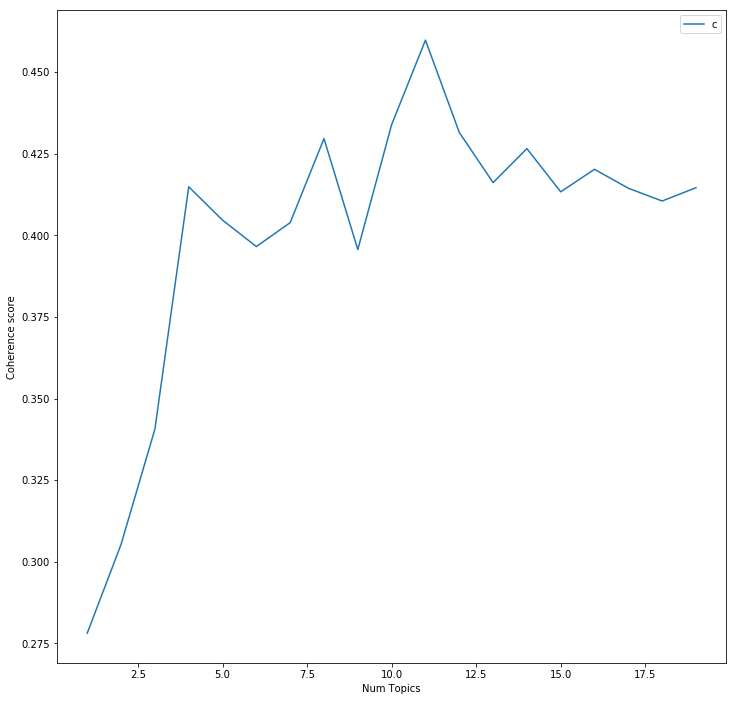

In [23]:
limit=20; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2782
Num Topics = 2  has Coherence Value of 0.3054
Num Topics = 3  has Coherence Value of 0.3407
Num Topics = 4  has Coherence Value of 0.4149
Num Topics = 5  has Coherence Value of 0.4047
Num Topics = 6  has Coherence Value of 0.3966
Num Topics = 7  has Coherence Value of 0.4039
Num Topics = 8  has Coherence Value of 0.4297
Num Topics = 9  has Coherence Value of 0.3957
Num Topics = 10  has Coherence Value of 0.4339
Num Topics = 11  has Coherence Value of 0.4598
Num Topics = 12  has Coherence Value of 0.4316
Num Topics = 13  has Coherence Value of 0.4162
Num Topics = 14  has Coherence Value of 0.4266
Num Topics = 15  has Coherence Value of 0.4134
Num Topics = 16  has Coherence Value of 0.4203
Num Topics = 17  has Coherence Value of 0.4145
Num Topics = 18  has Coherence Value of 0.4106
Num Topics = 19  has Coherence Value of 0.4146


### Seeing the coherence values above, 11 topics yeilds the highest coherence, so will stick to 11 topics for our data, seeing the graph above not so smooth means that data needs further preprocessing to make a smooth curve

In [25]:
# Select the model and print the topics

optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"infection" + 0.017*"virus" + 0.017*"case" + 0.016*"sars_cov" + '
  '0.012*"covid" + 0.010*"new" + 0.008*"antibody" + 0.008*"viral" + '
  '0.008*"present" + 0.006*"report"'),
 (1,
  '0.042*"cell" + 0.024*"cancer" + 0.012*"tumor" + 0.011*"expression" + '
  '0.007*"tissue" + 0.006*"lung" + 0.006*"treatment" + 0.005*"receptor" + '
  '0.005*"human" + 0.005*"chemotherapy"'),
 (2,
  '0.035*"patient" + 0.029*"study" + 0.018*"risk" + 0.014*"year" + '
  '0.013*"high" + 0.013*"group" + 0.011*"age" + 0.010*"factor" + '
  '0.010*"outcome" + 0.010*"associate"'),
 (3,
  '0.020*"study" + 0.013*"health" + 0.012*"care" + 0.010*"intervention" + '
  '0.009*"social" + 0.009*"quality" + 0.008*"use" + 0.008*"participant" + '
  '0.007*"experience" + 0.007*"support"'),
 (4,
  '0.022*"protein" + 0.020*"gene" + 0.008*"genetic" + 0.008*"sequence" + '
  '0.007*"identify" + 0.007*"induce" + 0.007*"specie" + 0.007*"analysis" + '
  '0.007*"pathway" + 0.006*"study"'),
 (5,
  '0.029*"use" + 0.019*"model"

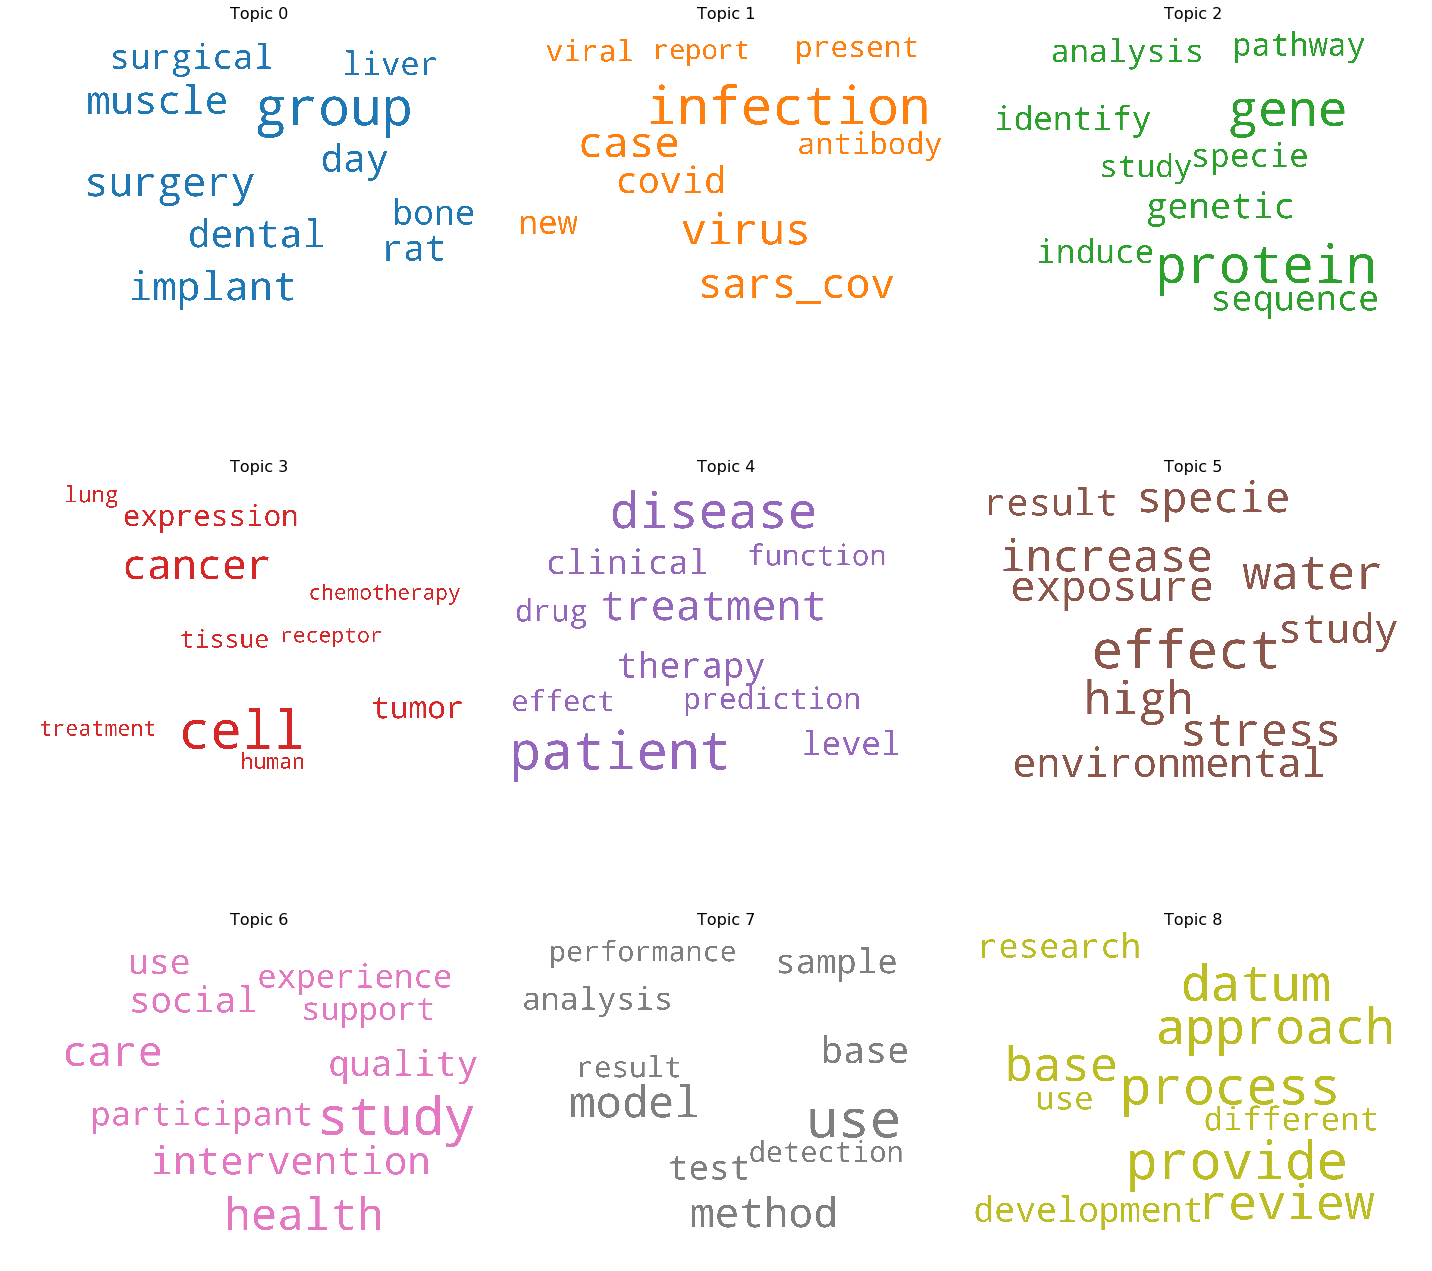

In [26]:
# Wordcloud of Top N words in each topic, I investigated the  top 10 words below
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

* **Topic 0:**  Includes surgeries and implants
* **Topic 1:**  Includes viruses and infections
* **Topic 2:**  Includes genes and proteins
* **Topic 3:**  Includes cancer and tumors
* **Topic 4:**  Includes patients and diseases
* **Topic 5:**  Includes stress and its effect
* **Topic 6:**  Includes health and study
* **Topic 7:**  Includes methods and analysis
* **Topic 8:**  Includes process and development
* **Topic 9:**  Includes patient and factors


### Next step is making the ourput dataframe:

In [27]:
topics_df1 = pd.DataFrame()
topics_df2 = pd.DataFrame()
topics_df3 = pd.DataFrame()

for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if len(row) >= 3:        
            if j ==0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])

                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
            elif j ==1:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
            elif j ==2:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                topics_df3 = topics_df3.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
            else:
                break
        elif len(row) == 2:
            if j ==0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
            elif j ==1:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)
        elif len(row) == 1:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
            
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic, topic_keywords]), ignore_index=True)
                topics_df2 = topics_df2.append(pd.Series(['-', '-']), ignore_index=True)  
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)        
                
            
topics_df1.rename(columns={0:'1st Topic', 1:'1st Topic Contribution', 2: '1st topic names'}, inplace=True)
topics_df2.rename(columns={0:'2nd Topic', 1:'2nd Topic Contribution', 2: '2nd topic names'}, inplace=True)
topics_df3.rename(columns={0:'3rd Topic', 1:'3rd Topic Contribution', 2: '3rd topic names'}, inplace=True)

topics_comb = pd.concat([data.ArticleID,topics_df1, topics_df2, topics_df3, data.Title, data.Abstract],  axis=1, sort=False)

In [28]:
topics_comb.head(10)

,ArticleID,1st Topic,1st Topic Contribution,1st topic names,2nd Topic,2nd Topic Contribution,2nd topic names,3rd Topic,3rd Topic Contribution,3rd topic names,Title,Abstract
0,34153941,2.0,0.431767,"patient, study, risk, year, high, group, age, ...",7.0,0.287443,"provide, process, datum, approach, review, bas...",5.0,0.166980,"use, model, method, base, test, sample, analys...",Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...
1,34153942,2.0,0.628319,"patient, study, risk, year, high, group, age, ...",7.0,0.127663,"provide, process, datum, approach, review, bas...",3.0,0.085566,"study, health, care, intervention, social, qua...",Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...
2,34153964,2.0,0.486549,"patient, study, risk, year, high, group, age, ...",0.0,0.184298,"infection, virus, case, sars_cov, covid, new, ...",5.0,0.142495,"use, model, method, base, test, sample, analys...",Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...
3,34153968,2.0,0.813085,"patient, study, risk, year, high, group, age, ...",5.0,0.042570,"use, model, method, base, test, sample, analys...",10.0,0.035539,"patient, disease, treatment, therapy, clinical...",Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...
4,34153978,9.0,0.547796,"health, covid, child, community, public, pande...",2.0,0.202906,"patient, study, risk, year, high, group, age, ...",7.0,0.086414,"provide, process, datum, approach, review, bas...",Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...
5,34153979,2.0,0.321484,"patient, study, risk, year, high, group, age, ...",3.0,0.313842,"study, health, care, intervention, social, qua...",9.0,0.305251,"health, covid, child, community, public, pande...",Testing the feasibility and acceptability of a...,"Despite growing numbers in the USA, immigrant ..."
6,34153980,10.0,0.509607,"patient, disease, treatment, therapy, clinical...",7.0,0.163198,"provide, process, datum, approach, review, bas...",5.0,0.105877,"use, model, method, base, test, sample, analys...",Lupus nephritis and ANCA-associated vasculitis...,Historically the treatment of lupus nephritis ...
7,34153982,10.0,0.589810,"patient, disease, treatment, therapy, clinical...",7.0,0.168018,"provide, process, datum, approach, review, bas...",9.0,0.095622,"health, covid, child, community, public, pande...",Precision medicine in diabetic nephropathy and...,Progressive chronic kidney disease (CKD) in in...
8,34153983,10.0,0.533566,"patient, disease, treatment, therapy, clinical...",2.0,0.144107,"patient, study, risk, year, high, group, age, ...",7.0,0.134722,"provide, process, datum, approach, review, bas...",Precision medicine in immunoglobulin A nephrop...,Immunoglobulin A nephropathy (IgAN) is the mos...
9,34153984,5.0,0.251780,"use, model, method, base, test, sample, analys...",1.0,0.178640,"cell, cancer, tumor, expression, tissue, lung,...",10.0,0.164087,"patient, disease, treatment, therapy, clinical...",Precision medicine in transplantation and hemo...,"In kidney transplantation, precision medicine ..."


### We see above, the top 3 topics for each article and matching score for each topic. 

### Saving the output to a csv file

In [29]:
topics_comb.to_csv('Top3TopicModeling.csv')  